In [ ]:
#-----------------------------#
# Dogs and Cats Classification Baseline-Model
#-----------------------------#
import os
import cv2
import shutil
from sklearn.utils import shuffle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import zipfile
def extract_zip(file_path, extract_to=None):
    if not zipfile.is_zipfile(file_path):
        print(f"The file '{file_path}' is not a valid ZIP file.")
        return
    if extract_to is None:
        extract_to = os.path.splitext(file_path)[0]
    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"ZIP file extracted to: {extract_to}")
    except Exception as e:
        print(f"An error occurred while extracting the ZIP file: {e}")

zip_file_path = "/content/Dog vs Cat Dataset and Code.zip"
extract_zip(zip_file_path)

ZIP file extracted to: /content/Dog vs Cat Dataset and Code


# Salt and Papper

In [ ]:
# Function to load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isfile(file_path):
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize to 128x128
                images.append(img)
                labels.append(label)
    return images, labels

# Paths to the training and testing directories
train_cat_dir = "/content/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/dataset/training_set/cats/salt_and_pepper_noise"
train_dog_dir = "/content/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/dataset/training_set/dogs/salt_and_pepper_noise"
test_cat_dir = "/content/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/dataset/test_set/cats/salt_and_pepper_noise"
test_dog_dir = "/content/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/dataset/test_set/dogs/salt_and_pepper_noise"

# Load training data
cat_train_images, cat_train_labels = load_images_from_folder(train_cat_dir, label=0)
dog_train_images, dog_train_labels = load_images_from_folder(train_dog_dir, label=1)

# Load testing data
cat_test_images, cat_test_labels = load_images_from_folder(test_cat_dir, label=0)
dog_test_images, dog_test_labels = load_images_from_folder(test_dog_dir, label=1)

# Combine training data
train_images = np.array(cat_train_images + dog_train_images)
train_labels = np.array(cat_train_labels + dog_train_labels)

# Combine testing data
test_images = np.array(cat_test_images + dog_test_images)
test_labels = np.array(cat_test_labels + dog_test_labels)

In [ ]:
# Function to save images to folders
def save_images_to_folder(images, labels, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i, (img, label) in enumerate(zip(images, labels)):
        # Create a subdirectory for each label (e.g., cats = 0, dogs = 1)
        label_dir = os.path.join(output_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # Save the image
        filename = f"image_{i}.jpg"
        cv2.imwrite(os.path.join(label_dir, filename), img)

# Output directories for training and testing sets
output_train_dir = "/content/saved_dataset_noise_1/training_SP"
output_test_dir = "/content/saved_dataset_noise_1/testing_SP"

# Save training data
save_images_to_folder(train_images, train_labels, output_train_dir)

# Save testing data
save_images_to_folder(test_images, test_labels, output_test_dir)

print("Images saved successfully to folders!")

Images saved successfully to folders!


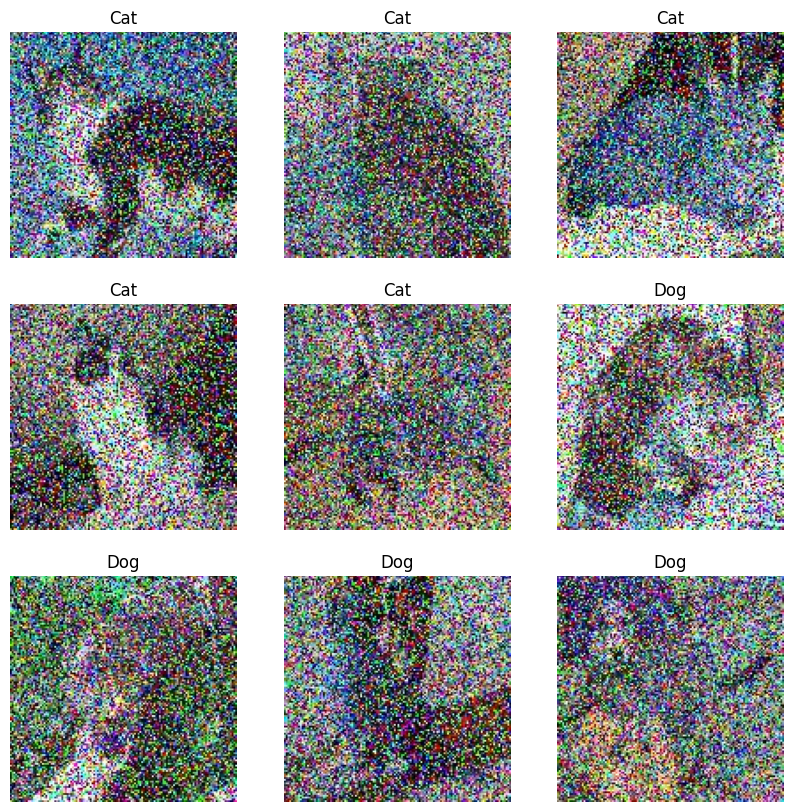

In [ ]:

# Combine training data
X_train = np.array(cat_train_images + dog_train_images)
y_train = np.array(cat_train_labels + dog_train_labels)

# Combine test data
X_val = np.array(cat_test_images + dog_test_images)
y_val = np.array(cat_test_labels + dog_test_labels)
# ---- Visualize Training Data ----
plt.figure(figsize=(10, 10))

# Find indexes for the first few images of each class
cat_indexes = np.where(y_train == 0)[0][:5]  # First 5 cat images
dog_indexes = np.where(y_train == 1)[0][:4]  # First 4 dog images

# Combine indexes to get a mix of cat and dog images
sample_indexes = np.concatenate([cat_indexes, dog_indexes])

# Display the images
for i, idx in enumerate(sample_indexes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[idx].astype('uint8'))  # Ensure uint8 type for displaying
    plt.title("Cat" if y_train[idx] == 0 else "Dog")
    plt.axis("off")

plt.show()

In [ ]:

# Function for Zero Padding
def zero_padding(image, pad_width):
    padded_image = np.zeros(
        (image.shape[0] + 2 * pad_width, image.shape[1] + 2 * pad_width, image.shape[2]),
        dtype=image.dtype
    )
    padded_image[pad_width:-pad_width, pad_width:-pad_width] = image
    return padded_image

# Median Filter Function with Zero Padding for Colored Images
def median_filter_color_with_padding(image, kernel_size=9, iterations=4):
    pad_width = kernel_size // 2
    filtered_image = image.copy()

    # Apply median filtering for a specified number of iterations
    for _ in range(iterations):
        padded_image = zero_padding(filtered_image, pad_width)
        new_filtered_image = np.zeros_like(filtered_image)

        # Loop over each pixel in the original image
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for c in range(image.shape[2]):  # Loop over each color channel
                    # Extract the neighborhood window from the padded image
                    window = padded_image[i:i + kernel_size, j:j + kernel_size, c]
                    # Compute the median of the window and assign it to the filtered image
                    new_filtered_image[i, j, c] = np.median(window)

        filtered_image = new_filtered_image.copy()

    return filtered_image

# Paths for input directory
input_dir = '/content/saved_dataset_noise_1/training_SP/0'

# Kernel size and iterations
kernel_size = 9
iterations = 4

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)

        # Load the image
        image = cv2.imread(input_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistent display

        # Apply median filtering with padding and multiple iterations
        denoised_image = median_filter_color_with_padding(image, kernel_size, iterations)

        # Convert back to BGR for saving
        denoised_image_bgr = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(input_path, denoised_image_bgr)


In [ ]:

# Function for Zero Padding
def zero_padding(image, pad_width):
    padded_image = np.zeros(
        (image.shape[0] + 2 * pad_width, image.shape[1] + 2 * pad_width, image.shape[2]),
        dtype=image.dtype
    )
    padded_image[pad_width:-pad_width, pad_width:-pad_width] = image
    return padded_image

# Median Filter Function with Zero Padding for Colored Images
def median_filter_color_with_padding(image, kernel_size=9, iterations=4):
    pad_width = kernel_size // 2
    filtered_image = image.copy()

    # Apply median filtering for a specified number of iterations
    for _ in range(iterations):
        padded_image = zero_padding(filtered_image, pad_width)
        new_filtered_image = np.zeros_like(filtered_image)

        # Loop over each pixel in the original image
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for c in range(image.shape[2]):  # Loop over each color channel
                    # Extract the neighborhood window from the padded image
                    window = padded_image[i:i + kernel_size, j:j + kernel_size, c]
                    # Compute the median of the window and assign it to the filtered image
                    new_filtered_image[i, j, c] = np.median(window)

        filtered_image = new_filtered_image.copy()

    return filtered_image

# Paths for input directory
input_dir = '/content/saved_dataset_noise_1/training_SP/1'

# Kernel size and iterations
kernel_size = 9
iterations = 4

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)

        # Load the image
        image = cv2.imread(input_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistent display

        # Apply median filtering with padding and multiple iterations
        denoised_image = median_filter_color_with_padding(image, kernel_size, iterations)

        # Convert back to BGR for saving
        denoised_image_bgr = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(input_path, denoised_image_bgr)


In [ ]:

# Function for Zero Padding
def zero_padding(image, pad_width):
    padded_image = np.zeros(
        (image.shape[0] + 2 * pad_width, image.shape[1] + 2 * pad_width, image.shape[2]),
        dtype=image.dtype
    )
    padded_image[pad_width:-pad_width, pad_width:-pad_width] = image
    return padded_image

# Median Filter Function with Zero Padding for Colored Images
def median_filter_color_with_padding(image, kernel_size=9, iterations=4):
    pad_width = kernel_size // 2
    filtered_image = image.copy()

    # Apply median filtering for a specified number of iterations
    for _ in range(iterations):
        padded_image = zero_padding(filtered_image, pad_width)
        new_filtered_image = np.zeros_like(filtered_image)

        # Loop over each pixel in the original image
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for c in range(image.shape[2]):  # Loop over each color channel
                    # Extract the neighborhood window from the padded image
                    window = padded_image[i:i + kernel_size, j:j + kernel_size, c]
                    # Compute the median of the window and assign it to the filtered image
                    new_filtered_image[i, j, c] = np.median(window)

        filtered_image = new_filtered_image.copy()

    return filtered_image

# Paths for input directory
input_dir = '/content/saved_dataset_noise_1/testing_SP/0'

# Kernel size and iterations
kernel_size = 9
iterations = 4

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)

        # Load the image
        image = cv2.imread(input_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistent display

        # Apply median filtering with padding and multiple iterations
        denoised_image = median_filter_color_with_padding(image, kernel_size, iterations)

        # Convert back to BGR for saving
        denoised_image_bgr = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(input_path, denoised_image_bgr)

In [ ]:

# Function for Zero Padding
def zero_padding(image, pad_width):
    padded_image = np.zeros(
        (image.shape[0] + 2 * pad_width, image.shape[1] + 2 * pad_width, image.shape[2]),
        dtype=image.dtype
    )
    padded_image[pad_width:-pad_width, pad_width:-pad_width] = image
    return padded_image

# Median Filter Function with Zero Padding for Colored Images
def median_filter_color_with_padding(image, kernel_size=9, iterations=4):
    pad_width = kernel_size // 2
    filtered_image = image.copy()

    # Apply median filtering for a specified number of iterations
    for _ in range(iterations):
        padded_image = zero_padding(filtered_image, pad_width)
        new_filtered_image = np.zeros_like(filtered_image)

        # Loop over each pixel in the original image
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for c in range(image.shape[2]):  # Loop over each color channel
                    # Extract the neighborhood window from the padded image
                    window = padded_image[i:i + kernel_size, j:j + kernel_size, c]
                    # Compute the median of the window and assign it to the filtered image
                    new_filtered_image[i, j, c] = np.median(window)

        filtered_image = new_filtered_image.copy()

    return filtered_image

# Paths for input directory
input_dir = '/content/saved_dataset_noise_1/testing_SP/1'

# Kernel size and iterations
kernel_size = 9
iterations = 4

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)

        # Load the image
        image = cv2.imread(input_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistent display

        # Apply median filtering with padding and multiple iterations
        denoised_image = median_filter_color_with_padding(image, kernel_size, iterations)

        # Convert back to BGR for saving
        denoised_image_bgr = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(input_path, denoised_image_bgr)

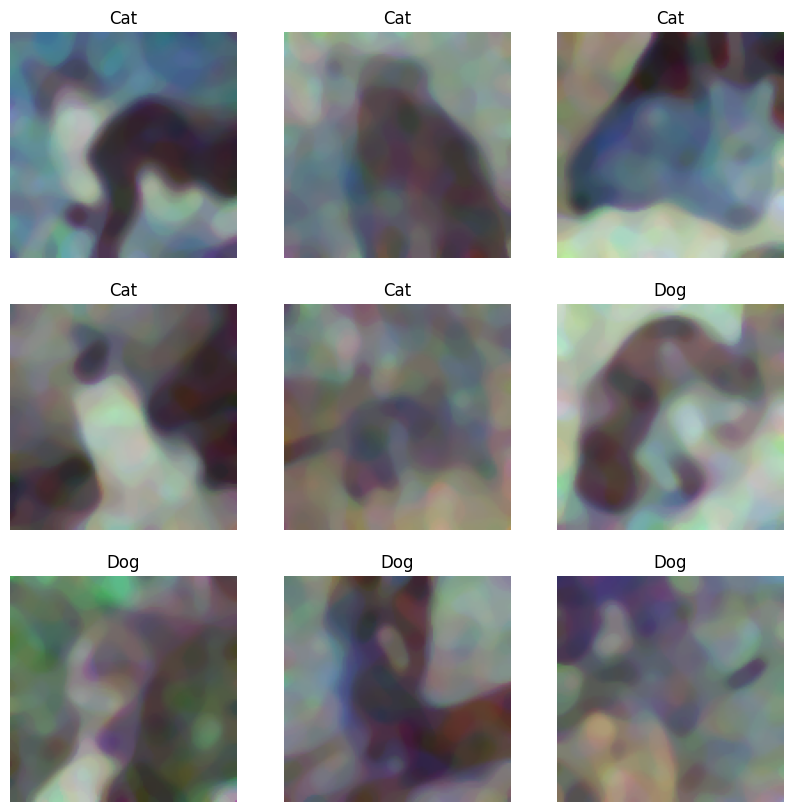

In [ ]:

# Custom Median Filter Function for Colored Images (No Padding)
def median_filter_color(image, kernel_size=9, iterations=4):
    filtered_image = image.copy()
    pad_width = kernel_size // 2

    # Apply median filtering for a specified number of iterations
    for _ in range(iterations):
        new_filtered_image = np.zeros_like(filtered_image)

        # Loop over each pixel (excluding edges)
        for i in range(pad_width, image.shape[0] - pad_width):
            for j in range(pad_width, image.shape[1] - pad_width):
                for c in range(image.shape[2]):  # Loop over each color channel
                    # Extract the neighborhood window
                    window = filtered_image[i - pad_width:i + pad_width + 1, j - pad_width:j + pad_width + 1, c]
                    # Compute the median and assign it to the new image
                    new_filtered_image[i, j, c] = np.median(window)

        # Update the filtered image
        filtered_image = new_filtered_image.copy()

    return filtered_image


# Combine training data (cat and dog images and their labels)
X_train = np.array(cat_train_images + dog_train_images)
y_train = np.array(cat_train_labels + dog_train_labels)

# Visualize Training Data after applying median filtering
plt.figure(figsize=(10, 10))

# Find indexes for the first few images of each class
cat_indexes = np.where(y_train == 0)[0][:5]  # First 5 cat images
dog_indexes = np.where(y_train == 1)[0][:4]  # First 4 dog images

# Combine indexes to get a mix of cat and dog images
sample_indexes = np.concatenate([cat_indexes, dog_indexes])

# Display the images after applying custom median filtering
for i, idx in enumerate(sample_indexes):
    ax = plt.subplot(3, 3, i + 1)

    # Apply custom median filtering on the selected image
    filtered_image = median_filter_color(X_train[idx], kernel_size=9, iterations=4)

    # Display the filtered image
    plt.imshow(filtered_image.astype('uint8'))  # Ensure uint8 type for displaying
    plt.title("Cat" if y_train[idx] == 0 else "Dog")
    plt.axis("off")

plt.show()

# Motion Blur

In [ ]:
# Function to load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isfile(file_path):
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize to 128x128
                images.append(img)
                labels.append(label)
    return images, labels

# Paths to the training and testing directories
train_cat_dir = "/content/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/dataset/training_set/cats/motion_blur"
train_dog_dir = "/content/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/dataset/training_set/dogs/motion_blur"
test_cat_dir = "/content/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/dataset/test_set/cats/motion_blur"
test_dog_dir = "/content/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/Dog vs Cat Dataset and Code/dataset/test_set/dogs/motion_blur"

# Load training data
cat_train_images, cat_train_labels = load_images_from_folder(train_cat_dir, label=0)
dog_train_images, dog_train_labels = load_images_from_folder(train_dog_dir, label=1)

# Load testing data
cat_test_images, cat_test_labels = load_images_from_folder(test_cat_dir, label=0)
dog_test_images, dog_test_labels = load_images_from_folder(test_dog_dir, label=1)

# Combine training data
train_images = np.array(cat_train_images + dog_train_images)
train_labels = np.array(cat_train_labels + dog_train_labels)

# Combine testing data
test_images = np.array(cat_test_images + dog_test_images)
test_labels = np.array(cat_test_labels + dog_test_labels)

In [ ]:
# Function to save images to folders
def save_images_to_folder(images, labels, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i, (img, label) in enumerate(zip(images, labels)):
        # Create a subdirectory for each label (e.g., cats = 0, dogs = 1)
        label_dir = os.path.join(output_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # Save the image
        filename = f"image_{i}.jpg"
        cv2.imwrite(os.path.join(label_dir, filename), img)

# Output directories for training and testing sets
output_train_dir = "/content/saved_dataset/training_B"
output_test_dir = "/content/saved_dataset/testing_B"

# Save training data
save_images_to_folder(train_images, train_labels, output_train_dir)

# Save testing data
save_images_to_folder(test_images, test_labels, output_test_dir)

print("Images saved successfully to folders!")

Images saved successfully to folders!


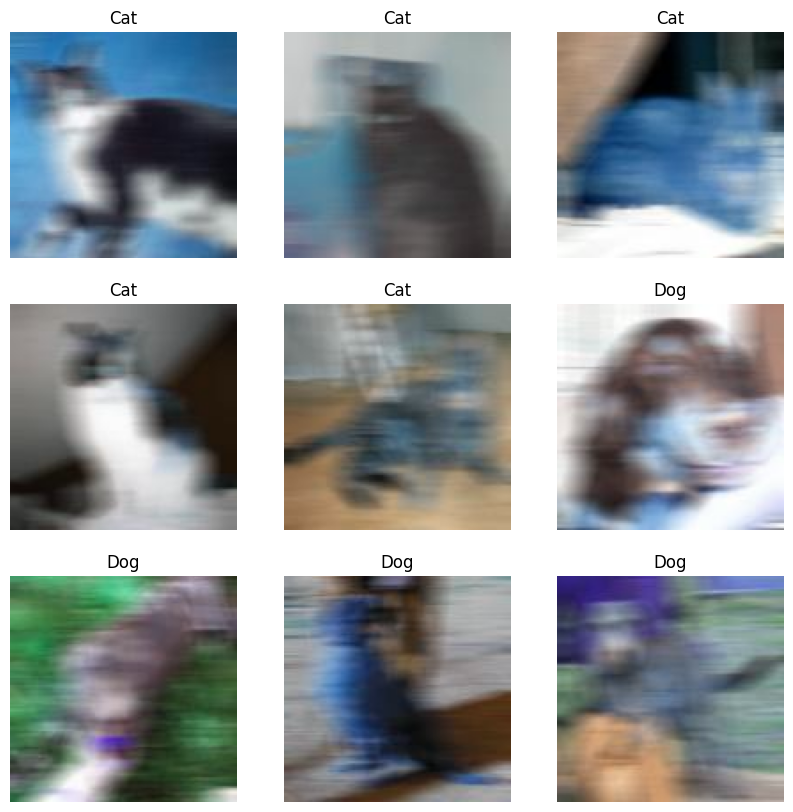

In [ ]:

import matplotlib.pyplot as plt
# Image parameters
img_size = 128
batch_size = 32
# Combine training data
X_train = np.array(cat_train_images + dog_train_images)
y_train = np.array(cat_train_labels + dog_train_labels)

# Combine test data
X_val = np.array(cat_test_images + dog_test_images)
y_val = np.array(cat_test_labels + dog_test_labels)
# ---- Visualize Training Data ----
plt.figure(figsize=(10, 10))

# Find indexes for the first few images of each class
cat_indexes = np.where(y_train == 0)[0][:5]  # First 5 cat images
dog_indexes = np.where(y_train == 1)[0][:4]  # First 4 dog images

# Combine indexes to get a mix of cat and dog images
sample_indexes = np.concatenate([cat_indexes, dog_indexes])

# Display the images
for i, idx in enumerate(sample_indexes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[idx].astype('uint8'))  # Ensure uint8 type for displaying
    plt.title("Cat" if y_train[idx] == 0 else "Dog")
    plt.axis("off")

plt.show()

In [ ]:
# Function to create the motion blur kernel (PSF)
def motion_blur_psf(length, angle):
    psf = np.zeros((length, length))
    center = length // 2
    for i in range(length):
        psf[center, i] = 1
    psf = cv2.warpAffine(psf, cv2.getRotationMatrix2D((center, center), angle, 1.0), (length, length))
    return psf / psf.sum()

# Function to apply Wiener filtering to color images with proper handling
def wiener_filter_precise_fixed(image, psf, k=0.01):
    """Applies Wiener filtering to a color image."""
    channels = cv2.split(image)
    restored_channels = []
    for channel in channels:
        # Convert to float for precise processing
        channel = channel.astype(np.float32)

        # Perform FFT of the image channel
        channel_fft = np.fft.fft2(channel)
        psf_fft = np.fft.fft2(psf, s=channel.shape)
        psf_fft = np.conj(psf_fft) / (np.abs(psf_fft)**2 + k)

        # Wiener filtering in the frequency domain
        deblurred_fft = channel_fft * psf_fft
        deblurred = np.abs(np.fft.ifft2(deblurred_fft))

        # Clip to valid range and convert back to uint8
        deblurred = np.clip(deblurred, 0, 255).astype(np.uint8)
        restored_channels.append(deblurred)

    # Merge restored channels
    return cv2.merge(restored_channels)

# Paths for input directory
input_dir = '/content/saved_dataset/training_B/0'  # Folder containing motion-blurred images

# Define the PSF (motion blur kernel)
psf_size = 20   # Kernel size ( based on the blur length)
psf_angle = 0  # Blur angle ( based on the blur direction)
psf_precise = motion_blur_psf(psf_size, psf_angle)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)

        # Load the image
        image = cv2.imread(input_path)

        # Apply the Wiener filter
        deblurred_image = wiener_filter_precise_fixed(image, psf_precise, k=0.01)

        # Save the deblurred image back to the same file
        cv2.imwrite(input_path, deblurred_image)

In [ ]:
# Function to create the motion blur kernel (PSF)
def motion_blur_psf(length, angle):
    psf = np.zeros((length, length))
    center = length // 2
    for i in range(length):
        psf[center, i] = 1
    psf = cv2.warpAffine(psf, cv2.getRotationMatrix2D((center, center), angle, 1.0), (length, length))
    return psf / psf.sum()

# Function to apply Wiener filtering to color images with proper handling
def wiener_filter_precise_fixed(image, psf, k=0.01):
    """Applies Wiener filtering to a color image."""
    channels = cv2.split(image)
    restored_channels = []
    for channel in channels:
        # Convert to float for precise processing
        channel = channel.astype(np.float32)

        # Perform FFT of the image channel
        channel_fft = np.fft.fft2(channel)
        psf_fft = np.fft.fft2(psf, s=channel.shape)
        psf_fft = np.conj(psf_fft) / (np.abs(psf_fft)**2 + k)

        # Wiener filtering in the frequency domain
        deblurred_fft = channel_fft * psf_fft
        deblurred = np.abs(np.fft.ifft2(deblurred_fft))

        # Clip to valid range and convert back to uint8
        deblurred = np.clip(deblurred, 0, 255).astype(np.uint8)
        restored_channels.append(deblurred)

    # Merge restored channels
    return cv2.merge(restored_channels)

# Paths for input directory
input_dir = '/content/saved_dataset/training_B/1'  # Folder containing motion-blurred images

# Define the PSF (motion blur kernel)
psf_size = 20   # Kernel size ( based on the blur length)
psf_angle = 0  # Blur angle ( based on the blur direction)
psf_precise = motion_blur_psf(psf_size, psf_angle)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)

        # Load the image
        image = cv2.imread(input_path)

        # Apply the Wiener filter
        deblurred_image = wiener_filter_precise_fixed(image, psf_precise, k=0.01)

        # Save the deblurred image back to the same file
        cv2.imwrite(input_path, deblurred_image)

In [ ]:
# Function to create the motion blur kernel (PSF)
def motion_blur_psf(length, angle):
    psf = np.zeros((length, length))
    center = length // 2
    for i in range(length):
        psf[center, i] = 1
    psf = cv2.warpAffine(psf, cv2.getRotationMatrix2D((center, center), angle, 1.0), (length, length))
    return psf / psf.sum()

# Function to apply Wiener filtering to color images with proper handling
def wiener_filter_precise_fixed(image, psf, k=0.01):
    """Applies Wiener filtering to a color image."""
    channels = cv2.split(image)
    restored_channels = []
    for channel in channels:
        # Convert to float for precise processing
        channel = channel.astype(np.float32)

        # Perform FFT of the image channel
        channel_fft = np.fft.fft2(channel)
        psf_fft = np.fft.fft2(psf, s=channel.shape)
        psf_fft = np.conj(psf_fft) / (np.abs(psf_fft)**2 + k)

        # Wiener filtering in the frequency domain
        deblurred_fft = channel_fft * psf_fft
        deblurred = np.abs(np.fft.ifft2(deblurred_fft))

        # Clip to valid range and convert back to uint8
        deblurred = np.clip(deblurred, 0, 255).astype(np.uint8)
        restored_channels.append(deblurred)

    # Merge restored channels
    return cv2.merge(restored_channels)

# Paths for input directory
input_dir = '/content/saved_dataset/testing_B/0'  # Folder containing motion-blurred images

# Define the PSF (motion blur kernel)
psf_size = 20   # Kernel size ( based on the blur length)
psf_angle = 0  # Blur angle ( based on the blur direction)
psf_precise = motion_blur_psf(psf_size, psf_angle)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)

        # Load the image
        image = cv2.imread(input_path)

        # Apply the Wiener filter
        deblurred_image = wiener_filter_precise_fixed(image, psf_precise, k=0.01)

        # Save the deblurred image back to the same file
        cv2.imwrite(input_path, deblurred_image)

In [ ]:
# Function to create the motion blur kernel (PSF)
def motion_blur_psf(length, angle):
    psf = np.zeros((length, length))
    center = length // 2
    for i in range(length):
        psf[center, i] = 1
    psf = cv2.warpAffine(psf, cv2.getRotationMatrix2D((center, center), angle, 1.0), (length, length))
    return psf / psf.sum()

# Function to apply Wiener filtering to color images with proper handling
def wiener_filter_precise_fixed(image, psf, k=0.01):
    """Applies Wiener filtering to a color image."""
    channels = cv2.split(image)
    restored_channels = []
    for channel in channels:
        # Convert to float for precise processing
        channel = channel.astype(np.float32)

        # Perform FFT of the image channel
        channel_fft = np.fft.fft2(channel)
        psf_fft = np.fft.fft2(psf, s=channel.shape)
        psf_fft = np.conj(psf_fft) / (np.abs(psf_fft)**2 + k)

        # Wiener filtering in the frequency domain
        deblurred_fft = channel_fft * psf_fft
        deblurred = np.abs(np.fft.ifft2(deblurred_fft))

        # Clip to valid range and convert back to uint8
        deblurred = np.clip(deblurred, 0, 255).astype(np.uint8)
        restored_channels.append(deblurred)

    # Merge restored channels
    return cv2.merge(restored_channels)

# Paths for input directory
input_dir = '/content/saved_dataset/testing_B/1'  # Folder containing motion-blurred images

# Define the PSF (motion blur kernel)
psf_size = 20   # Kernel size ( based on the blur length)
psf_angle = 0  # Blur angle ( based on the blur direction)
psf_precise = motion_blur_psf(psf_size, psf_angle)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)

        # Load the image
        image = cv2.imread(input_path)

        # Apply the Wiener filter
        deblurred_image = wiener_filter_precise_fixed(image, psf_precise, k=0.01)

        # Save the deblurred image back to the same file
        cv2.imwrite(input_path, deblurred_image)

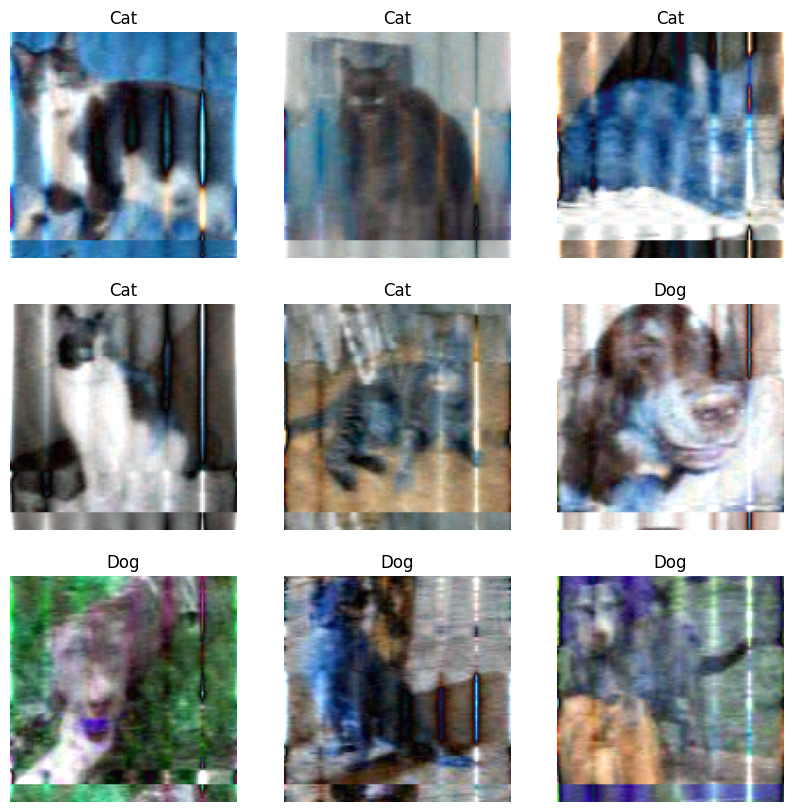

In [ ]:
# Function to apply Wiener filtering to color images with proper handling
def wiener_filter_precise_fixed(image, psf, k=0.01):
    """Applies Wiener filtering to a color image."""
    channels = cv2.split(image)
    restored_channels = []
    for channel in channels:
        # Convert to float for precise processing
        channel = channel.astype(np.float32)

        # Perform FFT of the image channel
        channel_fft = np.fft.fft2(channel)
        psf_fft = np.fft.fft2(psf, s=channel.shape)
        psf_fft = np.conj(psf_fft) / (np.abs(psf_fft)**2 + k)

        # Wiener filtering in the frequency domain
        deblurred_fft = channel_fft * psf_fft
        deblurred = np.abs(np.fft.ifft2(deblurred_fft))

        # Clip to valid range and convert back to uint8
        deblurred = np.clip(deblurred, 0, 255).astype(np.uint8)
        restored_channels.append(deblurred)

    # Merge restored channels
    return cv2.merge(restored_channels)

# Example: Define the PSF (motion blur kernel)
psf_size = 20  # Kernel size
psf_angle = 0  # Blur angle
psf_precise = motion_blur_psf(psf_size, psf_angle)

# Assuming X_train contains images
# Apply Wiener filtering to each image in X_train
X_train_processed = np.array([wiener_filter_precise_fixed(img, psf_precise) for img in X_train])

# Combine training data
X_train = np.array(cat_train_images + dog_train_images)
y_train = np.array(cat_train_labels + dog_train_labels)

# Combine test data
X_val = np.array(cat_test_images + dog_test_images)
y_val = np.array(cat_test_labels + dog_test_labels)

#Visualize Processed Training Data
plt.figure(figsize=(10, 10))

# Find indexes for the first few images of each class
cat_indexes = np.where(y_train == 0)[0][:5]  # First 5 cat images
dog_indexes = np.where(y_train == 1)[0][:4]  # First 4 dog images

# Combine indexes to get a mix of cat and dog images
sample_indexes = np.concatenate([cat_indexes, dog_indexes])

# Display the processed images
for i, idx in enumerate(sample_indexes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train_processed[idx].astype('uint8'))  # Ensure uint8 type for displaying
    plt.title("Cat" if y_train[idx] == 0 else "Dog")
    plt.axis("off")

plt.show()

In [ ]:
# Function to copy files to the target directory
def copy_files(source_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for file_name in os.listdir(source_dir):
        src_file = os.path.join(source_dir, file_name)
        dst_file = os.path.join(target_dir, file_name)
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)

# Define paths
dataset_paths = [
    ('/content/saved_dataset/testing_B/1', '/content/combine_datasets/testing/1'),
    ('/content/saved_dataset/testing_B/0', '/content/combine_datasets/testing/0'),
    ('/content/saved_dataset/training_B/1', '/content/combine_datasets/training/1'),
    ('/content/saved_dataset/training_B/0', '/content/combine_datasets/training/0'),
    ('/content/saved_dataset_noise_1/testing_SP/1', '/content/combine_datasets/testing/1'),
    ('/content/saved_dataset_noise_1/testing_SP/0', '/content/combine_datasets/testing/0'),
    ('/content/saved_dataset_noise_1/training_SP/1', '/content/combine_datasets/training/1'),
    ('/content/saved_dataset_noise_1/training_SP/0', '/content/combine_datasets/training/0'),
]

# Merge datasets
for src, dst in dataset_paths:
    copy_files(src, dst)

print("Datasets merged successfully!")

Datasets merged successfully!


In [ ]:
# Paths to the training and testing directories
train_cat_dir = "/content/combine_datasets/training/1"
train_dog_dir = "/content/combine_datasets/training/0"
test_cat_dir = "/content/combine_datasets/testing/1"
test_dog_dir = "/content/combine_datasets/testing/0"

# Load training data
cat_train_images, cat_train_labels = load_images_from_folder(train_cat_dir, label=1)  # Cats as 1
dog_train_images, dog_train_labels = load_images_from_folder(train_dog_dir, label=0)  # Dogs as 0

# Load testing data
cat_test_images, cat_test_labels = load_images_from_folder(test_cat_dir, label=1)  # Cats as 1
dog_test_images, dog_test_labels = load_images_from_folder(test_dog_dir, label=0)  # Dogs as 0

# Combine training data
X_train = np.array(cat_train_images + dog_train_images)
y_train = np.array(cat_train_labels + dog_train_labels)

# Combine testing data
X_val = np.array(cat_test_images + dog_test_images)
y_val = np.array(cat_test_labels + dog_test_labels)

# Check the shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (16000, 128, 128, 3), y_train shape: (16000,)
X_val shape: (4000, 128, 128, 3), y_val shape: (4000,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# No augmentation for Validation Set, just rescaling
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)


# Model and Results

In [ ]:
img_size = 128
batch_size = 32

# Define the CNN model
model = Sequential([
    # First block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Second block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Third block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,482,465 (17.10 MB)

 Trainable params: 4,482,017 (17.10 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/150


I0000 00:00:1733740826.663413     102 service.cc:145] XLA service 0x7d267400a2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733740826.663462     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733740826.663467     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.5156 - loss: 1.3571 

I0000 00:00:1733740839.627387     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.5442 - loss: 1.0132 - val_accuracy: 0.5940 - val_loss: 0.7240
Epoch 2/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.6110 - loss: 0.6646 - val_accuracy: 0.6018 - val_loss: 0.7347
Epoch 3/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6759 - loss: 0.5867 - val_accuracy: 0.6180 - val_loss: 0.8621
Epoch 4/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.7427 - loss: 0.4937 - val_accuracy: 0.6080 - val_loss: 1.1958
Epoch 5/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7742 - loss: 0.4369 - val_accuracy: 0.7060 - val_loss: 0.7782
Epoch 6/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.8040 - loss: 0.3789 - val_accuracy: 0.7262 - val_loss: 0.8222
Epoch 7/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.8042 - loss: 0.3585 - val_accuracy: 0.6880 - val_loss: 1.2312
Epoch 8/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.8129 - loss: 0.3473 - val_

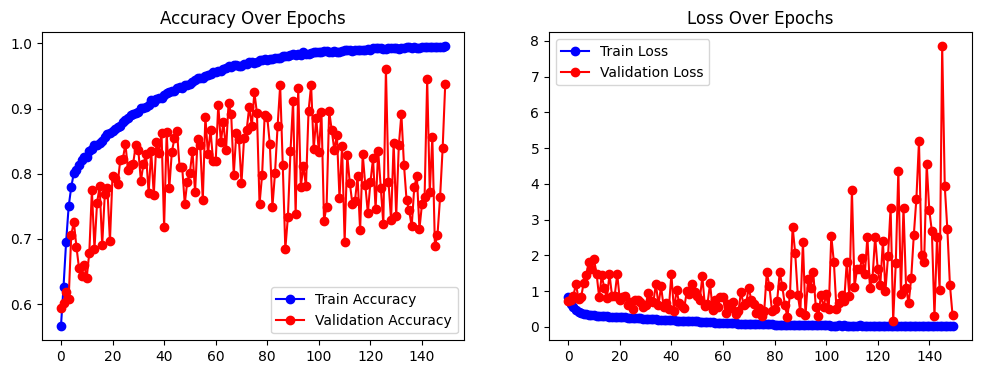

In [ ]:
# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
#callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    train_generator,
    epochs=150,
    batch_size=batch_size,
    validation_data=val_generator,
    #callbacks=callbacks
)


# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'bo-', label='Train Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Save the model
# model.save('dog_cat_classifier.h5')

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_generator)
print(f'Accuracy: {accuracy:.4f}')
print(f'Loss: {loss:.4f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9830 - loss: 0.0834
Accuracy: 0.9380
Loss: 0.3363


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


<Figure size 1600x800 with 0 Axes>

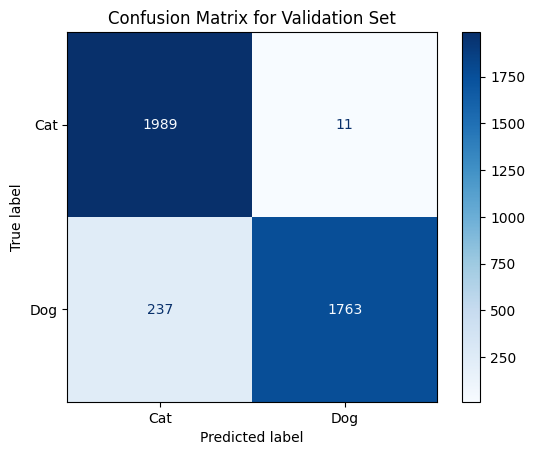

In [ ]:
# Confusion Matrix
# Step 1: Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)
# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
# Display the confusion matrix
plt.figure(figsize=(16, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Validation Set")
plt.show()

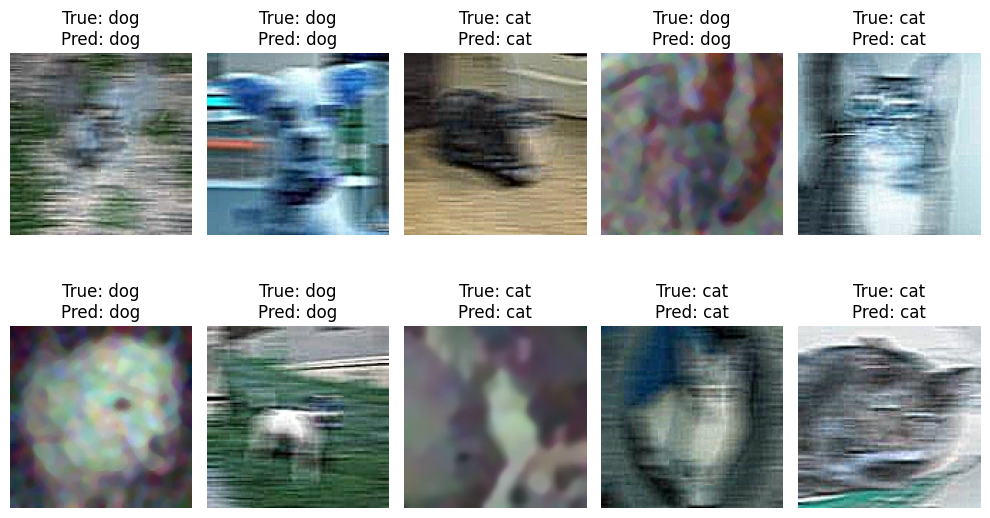

In [ ]:
# Random Predictions
# Define the number of samples and rows
num_samples = 10  # Total number of samples to display
num_cols = 5  # Number of columns per row
num_rows = (num_samples + num_cols - 1) // num_cols  # Calculate required rows
# Select random indices from the test set
random_indices = np.random.choice(len(X_val), num_samples, replace=False)
# Plot the random predictions
plt.figure(figsize=(10, num_rows * 3))
for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_val[idx], cmap='gray')  # Display the image
    # Get true and predicted labels
    true_label = 'dog' if y_val[idx] == 1 else 'cat'  # True label
    pred_label = 'dog' if y_pred[idx][0] == 1 else 'cat'  # Predicted label
    # Title for true and predicted labels
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()